# HNLs from Solar Atmospheric Neutrinos

Here, we calculate the production of Heavy Neutral Leptons (HNLs) from solar atmospheric neutrinos, through transition magnetic moments. Here are some useful references:

- JV, JL, et al ICRC on solar atmospheric neutrinos: https://arxiv.org/pdf/2107.13696
- HAWC observation of solar atmospheric neutrinos: https://arxiv.org/abs/2212.00815
- CAA et al calculation of solar atmospheric nu flux https://arxiv.org/abs/1703.07798

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("figures.mplstyle")
from matplotlib.colors import LogNorm
import pandas as pd
from scipy.interpolate import RegularGridInterpolator, interp1d

hbarc = 1.973e-14 # GeV cm
m_e = 0.511e-3 # GeV
mu_bohr = 1./(2*m_e) # GeV^-1
solar_solid_angle = 6.8e-5 # sr
n_density_sun = 1e25 # cm^-3, rough estimate

> **Physical Constants**  
> - `hbarc`: Natural unit conversion factor (ℏc = 1.973×10⁻¹⁴ GeV·cm)  
> - `m_e`: Electron mass (0.511 MeV)  
> - `mu_bohr`: Bohr magneton in natural units (1/2mₑ)  
> - `solar_solid_angle`: Sun's angular size as seen from Earth (~6.8×10⁻⁵ sr)  
> - `n_density_sun`: Reference solar number density (~10²⁵ cm⁻³)

# Define some neutrino parameters

### Flux

> **Solar Atmospheric Neutrino Flux Model**  
> This class handles two types of flux data from the CAA et al. data release:
> - **Pre-propagation**: Flux at production, parameterized by impact parameter `b` (distance from Sun center in solar radii)
> - **Post-propagation**: Flux at Earth after oscillations, integrated over the solar disk
> 
> The flux is multiplied by `solar_solid_angle` to convert from per-steradian to the Sun's angular extent.

In [2]:

class SolarAtmosphericNeutrinoFlux:

    def __init__(self,folder,type="pre"):

        self.fluxes = {}
        self.energy_range = None
        self.b_points = np.linspace(0,0.9,10)

        if type=="pre":
            flavors = ['nue','numu','nutau','anue','anumu','anutau']

            for ib,b in enumerate(self.b_points):
                data = np.loadtxt(f'{folder}/flux_b{b:.1f}.txt')
                if self.energy_range is None:
                    self.energy_range = data[:,0]
                for iflav, flav in enumerate(flavors):
                    if flav not in self.fluxes:
                        self.fluxes[flav] = np.empty((10, len(self.energy_range)))
                    self.fluxes[flav][ib,:] = data[:,iflav+1]

            # now set up interpolators
            self.flux_interpolators = {}
            for flav in self.fluxes:
                self.flux_interpolators[flav] = RegularGridInterpolator((self.b_points, self.energy_range), self.fluxes[flav], bounds_error=False, fill_value=None, method='cubic')

        elif type=="post":
            flavors = ['nue','numu','nutau']
            data = np.loadtxt(f'{folder}')
            if self.energy_range is None:
                self.energy_range = data[:,0]
            for iflav, flav in enumerate(flavors):
                self.fluxes[flav] = data[:,iflav+1]

            # now set up interpolators
            self.flux_interpolators = {}
            for flav in self.fluxes:
                self.flux_interpolators[flav] = interp1d(self.energy_range, self.fluxes[flav], bounds_error=False, fill_value=None, kind='cubic')

        else:
            raise ValueError("type must be 'pre' or 'post'")

    def flux(self, flav, energy, b=None):

        if b is not None:
            if type(b) == float:
                b = np.array([b]*len(energy))
            points = np.array([b, energy]).T
        else:
            points = energy
        return self.flux_interpolators[flav](points) * solar_solid_angle

    def integrated_flux(self, flav, energy, b_min, b_max):

        '''
        Compute the flux integrated over impact parameter b from b_min to b_max
        note that b is a radial coordinate in polar coordinates, so the integration measure is b db
        '''

        if type(b_min) == float:
            b_min = np.array([b_min]*len(energy))
        if type(b_max) == float:
            b_max = np.array([b_max]*len(energy))

        b_vals = np.linspace(b_min.min(), b_max.max(), 100)
        db = b_vals[1] - b_vals[0]

        fluxes = np.zeros(len(energy))
        for ib, b in enumerate(b_vals):
            mask = (b >= b_min) & (b <= b_max)
            if np.any(mask):
                points = np.array([np.full(np.sum(mask), b), energy[mask]]).T
                fluxes[mask] += 2 * b * solar_solid_angle * self.flux_interpolators[flav](points) * db

        return fluxes



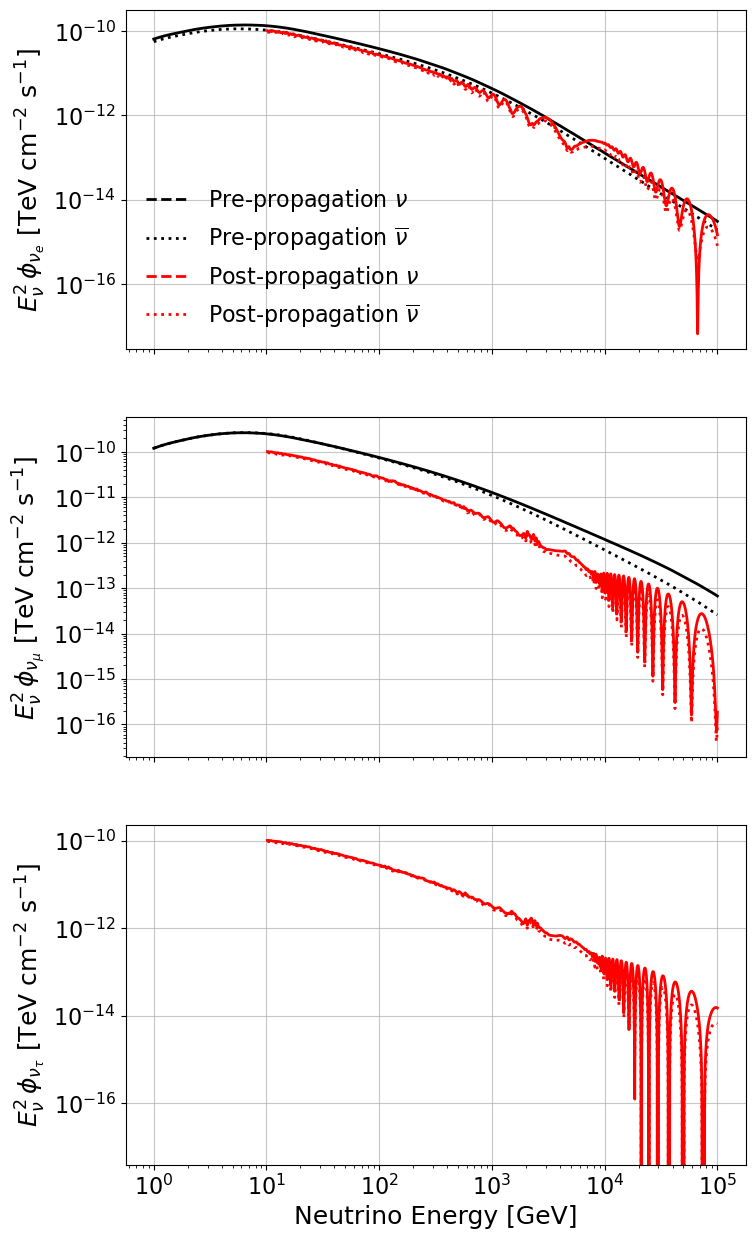

In [3]:
flux_model = "ppMRS_HillasGaisser_H4a"

pre_flux_model = SolarAtmosphericNeutrinoFlux('data/DataRelease/PrePropagation/SIBYLL2.3_'+flux_model,type='pre')
post_flux_model_nu = SolarAtmosphericNeutrinoFlux('/Users/nickkamp/Documents/Harvard/Research/Pheno/SolarHNL/data/DataRelease/PostPropagation/SIBYLL2.3_'+flux_model+'_nu.txt',type='post')
post_flux_model_nubar = SolarAtmosphericNeutrinoFlux('/Users/nickkamp/Documents/Harvard/Research/Pheno/SolarHNL/data/DataRelease/PostPropagation/SIBYLL2.3_'+flux_model+'_nubar.txt',type='post')

energy_points = np.logspace(0,5,10000)
reference_b = 0.0

fig,ax = plt.subplots(3,1,figsize=(8,15),sharex=True)

for i_f,flavor in enumerate(['nue','numu','nutau']):
    pre_f_nu = pre_flux_model.integrated_flux(flavor, energy_points, 0., 0.99)
    pre_f_nubar = pre_flux_model.integrated_flux('a'+flavor, energy_points, 0., 0.99)
    post_factor = 1./10 # somehow needed to match figure 7 in 1703.07798
    post_f_nu = post_flux_model_nu.flux(flavor, energy_points) * post_factor
    post_f_nubar = post_flux_model_nubar.flux(flavor, energy_points) * post_factor

    ax[i_f].plot(energy_points, 1e-3 * energy_points**2 * pre_f_nu, linestyle='-',color='black')
    ax[i_f].plot(energy_points, 1e-3 * energy_points**2 * pre_f_nubar, linestyle=':',color='black')
    ax[i_f].plot(energy_points, 1e-3 * energy_points**2 * post_f_nu, linestyle='-',color='red')
    ax[i_f].plot(energy_points, 1e-3 * energy_points**2 * post_f_nubar, linestyle=':',color='red')

ax[0].plot([],[],linestyle='--',color='black',label=r'Pre-propagation $\nu$')
ax[0].plot([],[],linestyle=':',color='black',label=r'Pre-propagation $\overline{\nu}$')
ax[0].plot([],[],linestyle='--',color='red',label=r'Post-propagation $\nu$')
ax[0].plot([],[],linestyle=':',color='red',label=r'Post-propagation $\overline{\nu}$')
for i in range(3):
    ax[i].loglog()
    ax[i].grid(True,which='major',alpha=0.7)
ax[2].set_xlabel('Neutrino Energy [GeV]')
ax[0].set_ylabel(r'$E_\nu^2 \, \phi_{\nu_e}$ [TeV cm$^{-2}$ s$^{-1}$]')
ax[1].set_ylabel(r'$E_\nu^2 \, \phi_{\nu_\mu}$ [TeV cm$^{-2}$ s$^{-1}$]')
ax[2].set_ylabel(r'$E_\nu^2 \, \phi_{\nu_\tau}$ [TeV cm$^{-2}$ s$^{-1}$]')
ax[0].legend()
plt.show()

> **Flux Comparison Plot**  
> Compares pre- and post-propagation fluxes for all three neutrino flavors (νₑ, νμ, ντ).  
> Solid lines: neutrinos | Dotted lines: antineutrinos  
> Black: pre-propagation | Red: post-propagation

### cross sections and decay widths

> **HNL Production & Decay Physics**  
> - **Decay width**: Sum of mixing-induced decay (∝ G_F² m⁵ U²) and magnetic moment decay (∝ d² m³)
> - **Decay length**: L_dec = ℏc·(E/m)/Γ — boosted lifetime in the lab frame
> - **Cross section**: σ ∝ d²(ℏc)² for magnetic moment interactions

In [4]:
def HNL_decay_width(m_N, U2, d=0):
    """Calculate the decay width of a Heavy Neutral Lepton (HNL).

    Parameters:
    m_N : float
        Mass of the HNL in GeV.
    U2 : float
        Mixing parameter squared.
    d : float
        Transition magnetic moment in GeV^-1.

    Returns:
    float
        Decay width in GeV.
    """
    G_F = 1.1663787e-5 # Fermi coupling constant in GeV^-2
    mixing_gamma = (G_F**2 * m_N**5 * U2) / (192 * np.pi**3)
    magnetic_gamma = (d**2 * m_N**3) / (4 * np.pi)
    return mixing_gamma + magnetic_gamma

def decay_length(m_N, U2, d, E):
    gamma_val = HNL_decay_width(m_N, U2, d)
    return (hbarc * (E / m_N)) / gamma_val  # in cm

# Cross section in cm^2
# roughly correct up to order 1 factors
def xs(d,m):
    return d**2 * hbarc**2


## Now load the Sun

In [5]:
the_sun = pd.read_csv('data/SSM.dat', sep='\s+', comment='#')
# sun parameters
Lsun = 3.8418E+33 # erg/s
Rsun = 6.9598E+10 # cm

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_95266/506877203.py:1: SyntaxWarning: invalid escape sequence '\s'
  the_sun = pd.read_csv('data/SSM.dat', sep='\s+', comment='#')


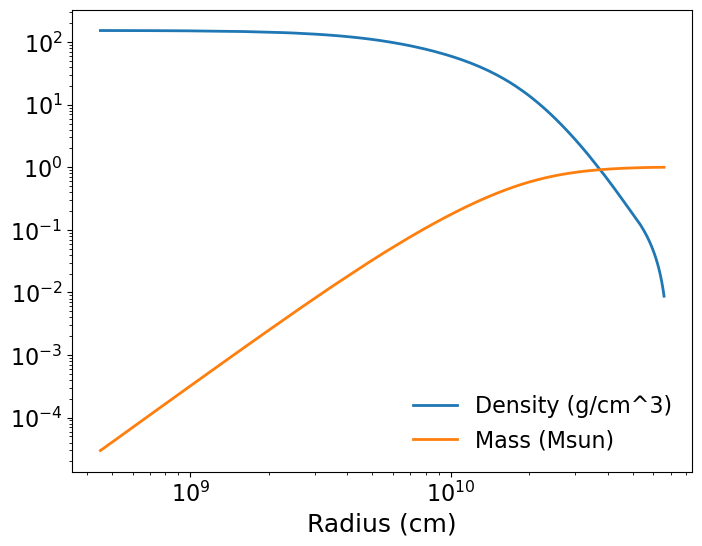

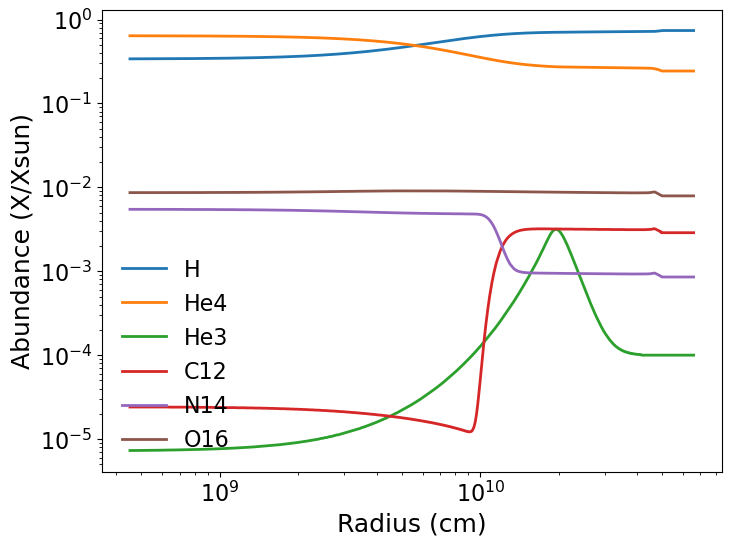

In [6]:
plt.plot(Rsun*the_sun['R/Rsun'], the_sun['Rho'],label='Density (g/cm^3)')
plt.plot(Rsun*the_sun['R/Rsun'], the_sun['M/Msun'],label='Mass (Msun)')
plt.loglog()
plt.legend()
plt.xlabel('Radius (cm)')
plt.show()

for element in ['X','Y','He3', 'C12', 'N14', 'O16']:
    if element=='X': label = 'H'
    elif element=='Y': label = 'He4'
    else: label = element
    plt.plot(Rsun*the_sun['R/Rsun'], the_sun[element],label=label)
plt.loglog()
plt.legend()
plt.xlabel('Radius (cm)')
plt.ylabel('Abundance (X/Xsun)')
plt.show()

## Now let's estimate the sensitive region of the parameter space

> **Parameter Space Scan Strategy**  
> We scan over HNL mass (mₙ) and magnetic moment (μ/μ_B) to identify the sensitive region:
> - **Interaction probability**: P_int = 1 − exp(−R☉/L_int) — must be large enough for production
> - **Decay length**: L_dec ~ R☉ — HNL should decay before escaping the Sun (for detection)
> 
> The "sweet spot" is where both conditions are satisfied simultaneously.

In [7]:
mass_range = np.logspace(-4, 0, 50)  # Mass range from 1 MeV to 1 TeV
mu_range = np.logspace(-12, -2, 51)  # Magnetic moment
energy = 1e3  # Neutrino energy in GeV
decay_length_vals = np.zeros((len(mass_range), len(mu_range)))
interaction_length_vals = np.zeros((len(mass_range), len(mu_range)))
for i, m in enumerate(mass_range):
    for j, mu in enumerate(mu_range):
        d = mu/2
        gamma_val = HNL_decay_width(m, 0 ,)
        decay_length_vals[i, j] = decay_length(m, 0, d, energy)  # in cm
        interaction_length_vals[i, j] = 1./(n_density_sun * xs(d, m))  # in cm

int_prob = 1 - np.exp(-Rsun / interaction_length_vals)

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_95266/2052347590.py:1: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(mass_range, mu_range/mu_bohr, decay_length_vals.T/Rsun, levels=[1], colors='orange',labels=[r'$L_{\rm dec} = R_{\odot}$'])


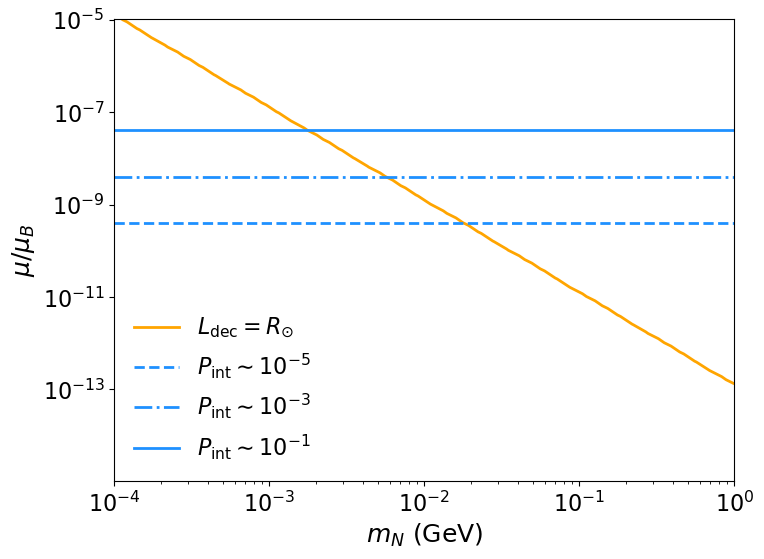

In [8]:
plt.contour(mass_range, mu_range/mu_bohr, decay_length_vals.T/Rsun, levels=[1], colors='orange',labels=[r'$L_{\rm dec} = R_{\odot}$'])


#plt.pcolormesh(mass_range, mu_range/mu_bohr, int_prob.T, shading='auto', norm=LogNorm(vmin=1e-10))
#c = plt.colorbar()
#c.set_label(r'Interaction Probability $P_{\rm int}$')
cs = plt.contour(mass_range,mu_range/mu_bohr, int_prob.T, levels=[1e-5,1e-3,1e-1],colors="dodgerblue",linestyles=['--','-.','-'])


# label contours
plt.plot([],[],color='orange',label=r'$L_{\rm dec} = R_{\odot}$')
plt.plot([],[],color='dodgerblue',linestyle='--',label=r'$P_{\rm int} \sim 10^{-5}$')
plt.plot([],[],color='dodgerblue',linestyle='-.',label=r'$P_{\rm int} \sim 10^{-3}$')
plt.plot([],[],color='dodgerblue',linestyle='-',label=r'$P_{\rm int} \sim 10^{-1}$')

plt.loglog()
plt.xlabel(r'$m_N$ (GeV)')
plt.ylabel(r'$\mu/\mu_B$')
plt.legend(loc='lower left')

> **Contour Plot Interpretation**  
> - 🟠 **Orange**: Decay length equals solar radius (L_dec = R☉)
> - 🔵 **Blue dashed/dot-dashed/solid**: Interaction probabilities of 10⁻⁵, 10⁻³, 10⁻¹
> 
> Region of interest: Below the orange line (HNL decays inside Sun) AND above blue contours (sufficient production)